In [1]:
from encoder import inference as encoder
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import glob
import numpy as np
import seaborn as sns
import IPython
import librosa

In [6]:
encoder_model_path = Path('./encoder/saved_models/voxlib.pt')
encoder.load_model(encoder_model_path)

Loaded encoder "voxlib.pt" trained to step 1239501


In [7]:
p_path_dict = {
    'libr1': ['LibriSpeech/dev-clean/1272/128104/'],
    'libr2': ['LibriSpeech/dev-clean/3752/4943/'],
    'libr3': ['LibriSpeech/dev-clean/1462/170138/'],
    'libr4': ['LibriSpeech/dev-clean/174/168635/']}
#     'libr5': ['/Users/jin_bose/git/data/LibriSpeech/dev-clean/2035/147960/'],
    
   # 'jin_aud': ['/Users/jin_bose/git/data/record_voice/jin_audacity/'],
   # 'jin_mac': ['/Users/jin_bose/git/data/record_voice/jin_mac/'],
    #'jin_iphone': ['/Users/jin_bose/git/data/record_voice/jin_iphone/'],
    #'lin_aud': ['/Users/jin_bose/git/data/record_voice/linlin_audacity/'],
    #'lin_mac': ['/Users/jin_bose/git/data/record_voice/linlin_mac/'],
    #'lin_iphone': ['/Users/jin_bose/git/data/record_voice/linlin_iphone/'],



In [8]:
def get_emb_for_all_wavs(paths):
    res = []
    for path in paths:
        files = glob.glob(path+'/*.flac')
        files = files + glob.glob(path+'/*.wav')
        for f in files:
            preprocessed_wav = encoder.preprocess_wav(f)
            embed = encoder.embed_utterance(preprocessed_wav)
            res.append(embed)
    return np.asarray(res)

In [9]:
emb_by_u = {}
for p in p_path_dict:
    emb_by_u[p] = get_emb_for_all_wavs(p_path_dict[p])

In [21]:
for i in emb_by_u:
    print('User:', i, '\t utt number:', emb_by_u[i].shape[0],emb_by_u[i].shape )

User: libr1 	 utt number: 15 (15, 256)
User: libr2 	 utt number: 31 (31, 256)
User: libr3 	 utt number: 28 (28, 256)
User: libr4 	 utt number: 23 (23, 256)


# try to use spectral cluster

https://github.com/wq2012/SpectralCluster
doesn't wokr

In [49]:
# using different speaker samples to try cluster

samples = np.vstack([emb_by_u['libr1'][2],emb_by_u['libr4'][2],emb_by_u['libr1'][4],emb_by_u['libr4'][4],emb_by_u['libr1'][3],emb_by_u['libr4'][3],emb_by_u['libr1'][5],emb_by_u['libr4'][5]])

In [47]:
samples.shape

(8, 256)

## sklearn spec cluster

In [51]:
X=samples

In [52]:
>>> from sklearn.cluster import SpectralClustering
>>> import numpy as np

>>> clustering = SpectralClustering(n_clusters=2,
...         assign_labels="discretize",
...         random_state=0).fit(X)
>>> clustering.labels_


array([0, 1, 0, 1, 0, 1, 0, 1])

# pipeline 

- speech detection (YAMNET or other VAD) gives onsets and offsets of speech in 1s resolution(?)

- chunk speech into 1s? (if we assume one chunk only belongs to one person, we don't need to. but in this case, we might be unsure because there may not be a long pause between speakers so we do need to chunk

- generate embeddings and predict each 1s

- generate clustering

- generate final timestamps


In [1]:
from __future__ import division, print_function

import sys,os

import numpy as np
import resampy
import soundfile as sf
import tensorflow as tf

import params
import yamnet as yamnet_model


def analyze_audio(file_list,data_path):

    graph = tf.Graph()
    with graph.as_default():
        yamnet = yamnet_model.yamnet_frames_model(params)
        yamnet.load_weights('yamnet.h5')
    yamnet_classes = yamnet_model.class_names('yamnet_class_map.csv')
    return_dict = {}
    for fname in file_list:
        print(fname)
        file_name = os.path.join(data_path, fname)
        
        # Decode the WAV file.
        wav_data, sr = sf.read(file_name, dtype=np.int16)
        assert wav_data.dtype == np.int16, 'Bad sample type: %r' % wav_data.dtype
        waveform = wav_data / 32768.0  # Convert to [-1.0, +1.0]

        # Convert to mono and the sample rate expected by YAMNet.
        if len(waveform.shape) > 1:
            waveform = np.mean(waveform, axis=1)
        if sr != params.SAMPLE_RATE:
            waveform = resampy.resample(waveform, sr, params.SAMPLE_RATE)

        # Predict YAMNet classes.
        # Second output is log-mel-spectrogram array (used for visualizations).
        # (steps=1 is a work around for Keras batching limitations.)
        with graph.as_default():
            scores, spec = yamnet.predict(np.reshape(waveform, [1, -1]), steps=1)
        # Scores is a matrix of (time_frames, num_classes) classifier scores.
        # Average them along time to get an overall classifier output for the clip.
        #prediction = np.mean(scores, axis=0)
        # Report the highest-scoring classes and their scores.
        #top5_i = np.argsort(prediction)[::-1][:5]
        
        # print result for each file
        #print(file_name, ':\n' + 
         #     '\n'.join('  {:12s}: {:.3f}'.format(yamnet_classes[i], prediction[i])
          #              for i in top5_i))
        
        # we can just return a dict from each file name to top classes
        #results_dict = {}
        #for i in top5_i:
            #results_dict[yamnet_classes[i]] = prediction[i]
        #return_dict[fname]=results_dict
        
        #return_dict[fname] = scores
    return scores, spec

In [8]:
wav_file_name ='audio_data/4_ways_to_measure_social_media_ROI.wav'
#wav_data, sr = sf.read(wav_file_name, dtype=np.int16)
#waveform = wav_data / 32768.0

In [9]:
%matplotlib inline
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display

In [10]:
x, sr = librosa.load(wav_file_name,sr=16000)
#ipd.Audio(x, rate=sr)

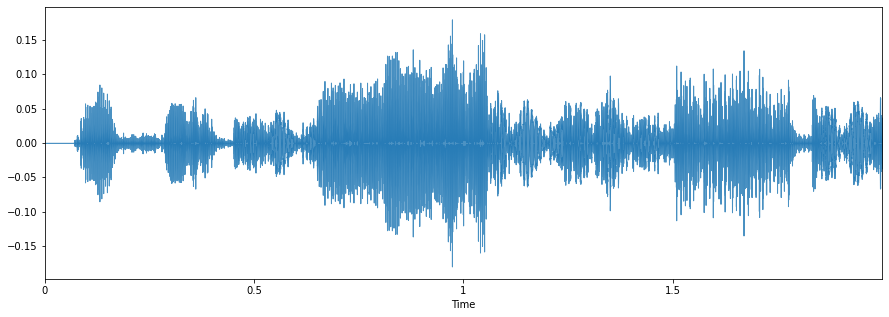

In [13]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x[:32000], sr, alpha=0.8)
plt.savefig("waveform.png")

<Figure size 432x288 with 0 Axes>

In [10]:
len(waveform)

22025216

In [14]:
len(x)

22025216

In [6]:
2**15

32768

In [2]:
files = ['4_ways_to_measure_social_media_ROI.wav']
path = 'audio_data'
scores,spec = analyze_audio(files, path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
4_ways_to_measure_social_media_ROI.wav


In [3]:
scores.shape

(1039, 521)

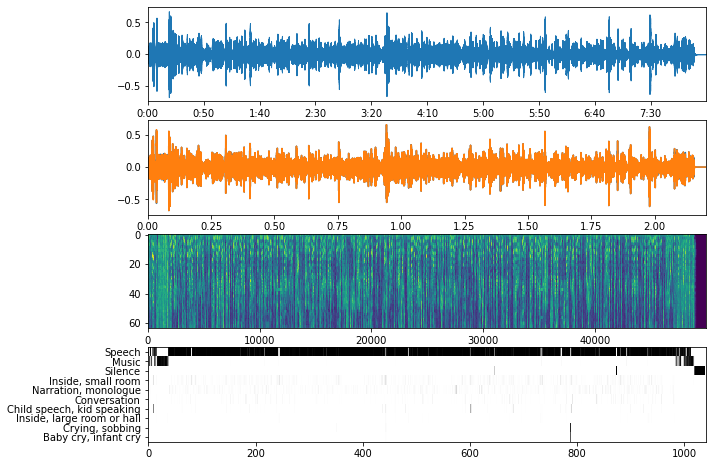

In [20]:
# Visualize the results.
plt.figure(figsize=(10, 8))
#librosa.display.waveplot(x, sr, alpha=0.8)

class_names = yamnet_model.class_names('yamnet_class_map.csv')
# Plot the waveform.
plt.subplot(4, 1, 1)
librosa.display.waveplot(x, sr=sr)

plt.subplot(4, 1, 2)
plt.plot(waveform)
plt.xlim([0, len(waveform)])

# Plot the log-mel spectrogram (returned by the model).
plt.subplot(4, 1, 3)
plt.imshow(spec.T, aspect='auto', interpolation='nearest', origin='upper')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_N = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_N]
plt.subplot(4, 1, 4)
plt.imshow(scores[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')
# Compensate for the PATCH_WINDOW_SECONDS (0.96 s) context window to align with spectrogram.
patch_padding = (params.PATCH_WINDOW_SECONDS / 2) / params.PATCH_HOP_SECONDS
plt.xlim([-patch_padding, scores.shape[0] + patch_padding])
# Label the top_N classes.
yticks = range(0, top_N, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_N, 0]))

In [72]:
scores.shape

(1039, 521)

# Visualize （Jin）


/Users/sz1033426/repo/tf-keras-crnn/.env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.
/Users/sz1033426/repo/tf-keras-crnn/.env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


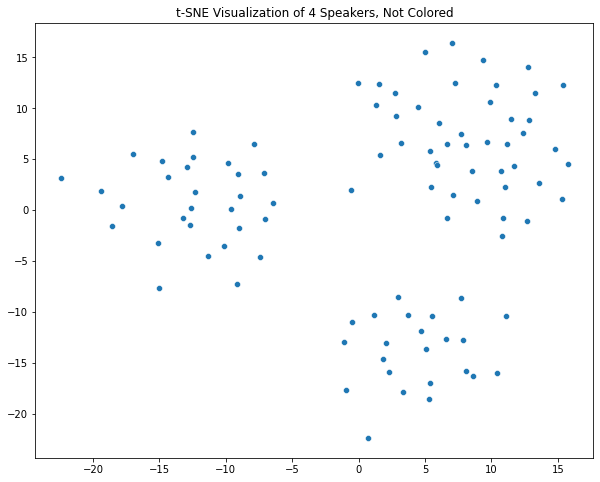

/Users/sz1033426/repo/tf-keras-crnn/.env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 't-SNE Visualization of 4 Speakers, Colored')

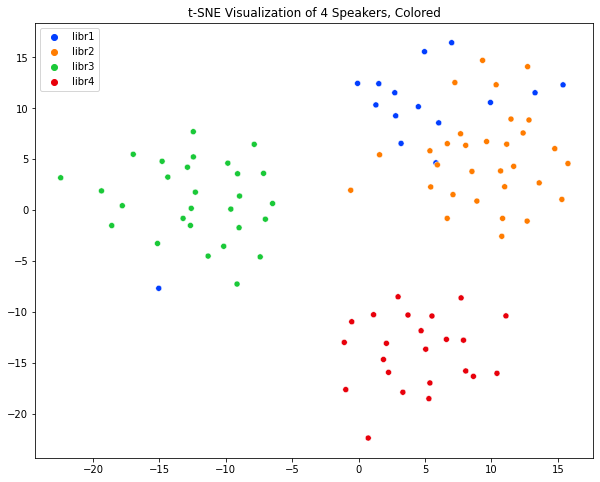

In [12]:
X = np.vstack(emb_by_u.values())
y = np.repeat(list(emb_by_u.keys()), [len(emb_by_u[i]) for i in emb_by_u])


tsne = TSNE(n_iter=266)
X_embedded = tsne.fit_transform(X)
X_embedded.shape

palette = sns.color_palette("bright", len(emb_by_u))

plt.figure(figsize=(10,8))
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full', palette=palette)
plt.title('t-SNE Visualization of 4 Speakers, Not Colored')
plt.show()

plt.figure(figsize=(10,8))
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full', palette=palette, hue=y)
plt.title('t-SNE Visualization of 4 Speakers, Colored')

/Users/sz1033426/repo/tf-keras-crnn/.env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.
/Users/sz1033426/repo/tf-keras-crnn/.env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


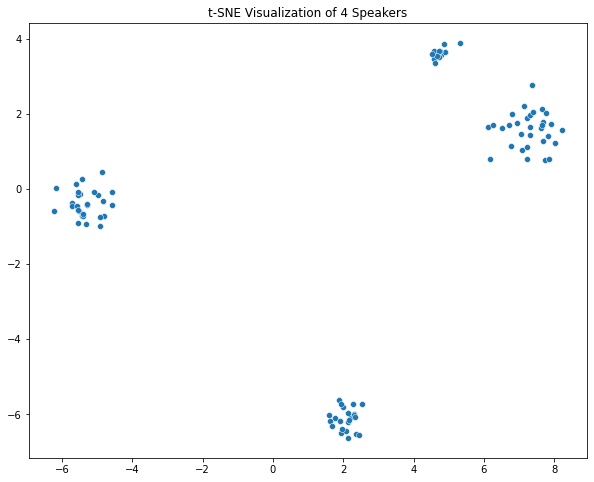

/Users/sz1033426/repo/tf-keras-crnn/.env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 't-SNE Visualization of 4 Speakers')

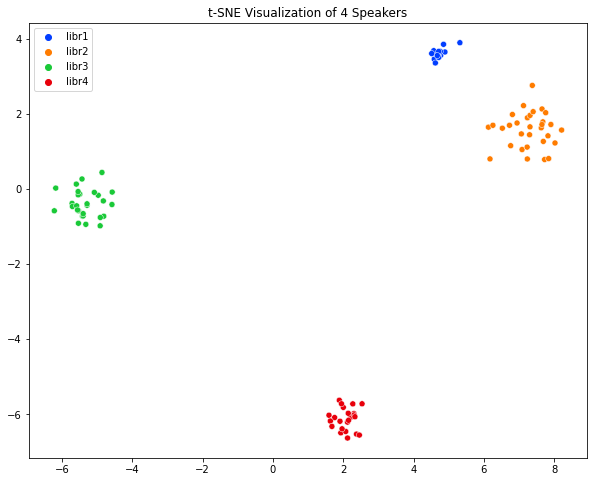

In [14]:
X = np.vstack(emb_by_u.values())
y = np.repeat(list(emb_by_u.keys()), [len(emb_by_u[i]) for i in emb_by_u])


tsne = TSNE(n_iter=2500)
X_embedded = tsne.fit_transform(X)
X_embedded.shape

palette = sns.color_palette("bright", len(emb_by_u))

plt.figure(figsize=(10,8))
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full', palette=palette)
plt.title('t-SNE Visualization of 4 Speakers')
plt.show()

plt.figure(figsize=(10,8))
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full', palette=palette, hue=y)
plt.title('t-SNE Visualization of 4 Speakers')

In [15]:
from sklearn.decomposition import PCA

In [16]:
pca = PCA(n_components=2)
X_embedded_pca = pca.fit_transform(X)

In [17]:
X_embedded_pca.shape, y.shape

((97, 2), (97,))

/Users/sz1033426/repo/tf-keras-crnn/.env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


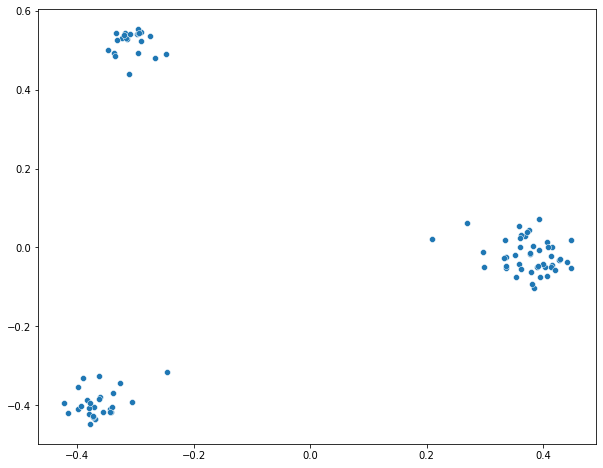

In [18]:
palette = sns.color_palette("bright", len(emb_by_u))

plt.figure(figsize=(10,8))
sns.scatterplot(X_embedded_pca[:,0], X_embedded_pca[:,1], legend='full', palette=palette)
plt.show()

/Users/sz1033426/repo/tf-keras-crnn/.env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

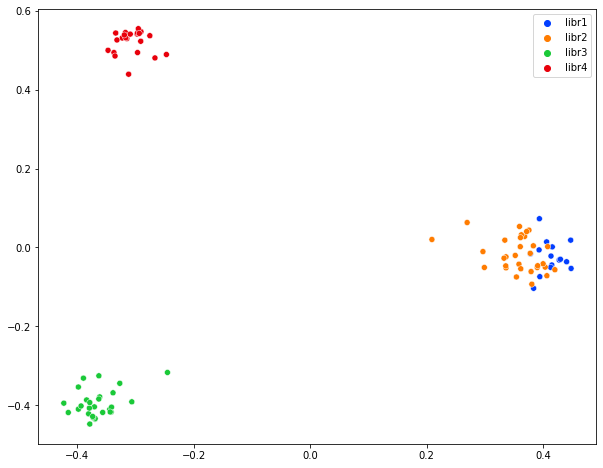

In [19]:
plt.figure(figsize=(10,8))
sns.scatterplot(X_embedded_pca[:,0], X_embedded_pca[:,1], legend='full', palette=palette, hue=y)

In [20]:
for person in p_path_dict:
    for path in p_path_dict[person]:
        files = glob.glob(path+'/*.flac')
        files = files + glob.glob(path+'/*.wav')
    dis_files = np.random.choice(files, 2)
    print('*'*40)
    print('Person:', person)
    for f in dis_files:
        if f.endswith('.flac'):
            y, sr = librosa.load(f)
            IPython.display.display(IPython.display.Audio(y, rate=sr))
        else:
            IPython.display.display(IPython.display.Audio(f))

****************************************
Person: libr1


****************************************
Person: libr2


****************************************
Person: libr3


****************************************
Person: libr4
